In [46]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from itertools import islice
import plotly.graph_objects as go
np.random.seed(0)

## Test with identity network

In [47]:
# Gradient approach

class IdentityNN(torch.nn.Module):
    def __init__(self):
        super(IdentityNN, self).__init__()
        self.fc1 = torch.nn.Linear(1, 2)
        self.fc2 = torch.nn.Linear(2, 1)
        self.init_weights()

    def init_weights(self):
        with torch.no_grad():
            self.fc1.weight[:] = torch.tensor([[1.0], [-1.0]])
            torch.nn.init.constant_(self.fc1.bias, 0)
            torch.nn.init.constant_(self.fc2.bias, 0)
            self.fc2.weight[:] = torch.tensor([[1.0, -1.0]])

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        output = self.fc2(x)
        return output
    
model = IdentityNN()

In [48]:
crossings = []
t_values = np.linspace(-10, 10, 10000)
x = torch.tensor(t_values).float()  # line 
x = x.view(-1, 1)

def compute_crossing_times(model, t_values):
    crossings = []
    x = torch.tensor(t_values).float()  # line 
    x = x.view(-1, 1)
    tol = 1e-5

    for l,layer in enumerate(model.children()):      # iterate over layers
        x = layer(x)
        activation = x>0
        for i in range(activation.shape[1]):    # iterate over neurons
            transition_indices = np.where(np.abs(np.diff(activation[:, i])) > tol)[0]
            for idx in transition_indices:
                crossings.append((l, i, t_values[idx]))
        x = torch.relu(x)
    crossing_times = [t for _,_,t in crossings]
    crossing_times = np.unique(crossing_times, axis=0)
    return crossing_times

def compute_gradients(model, crossing_times):
    dx = 1e-2
    grad = []

    t_min = crossing_times[0] - 2 * dx
    x = torch.tensor([t_min, t_min + dx]).float().view(-1, 1)
    with torch.no_grad():
        y = model(x)
    dy = np.diff(y.numpy().reshape(-1))
    grad.append(dy/dx)
    
    for t in crossing_times:
        x = torch.tensor([t + dx, t + 2*dx]).float().view(-1, 1)
        with torch.no_grad():
            y = model(x)
        dy = np.diff(y.numpy().reshape(-1))
        grad.append(dy/dx) 
    
    grad = np.array(grad)
    return grad

crossing_times = compute_crossing_times(model, t_values)
grad = compute_gradients(model, crossing_times)

for i in range(1, len(crossing_times)+1):
    if np.abs(grad[i-1] - grad[i]) < 1e-5:
        crossing_times = np.delete(crossing_times, i-1)
print(crossing_times)


"""
with torch.no_grad():
    y= model(x)

dx = np.diff(x.numpy().reshape(-1))
dy = np.diff(y.numpy().reshape(-1))

print(dy[[498, 500]])
grad = dy/dx

def merge_sequences(arr : np.array):
    merged = [arr[0]]
    for i in range(1, len(arr)):
        if arr[i] != arr[i - 1]:
            merged.append(arr[i])
    return merged

unique_grad = np.unique(grad, return_index=True)
print(unique_grad)
"""

[]


'\nwith torch.no_grad():\n    y= model(x)\n\ndx = np.diff(x.numpy().reshape(-1))\ndy = np.diff(y.numpy().reshape(-1))\n\nprint(dy[[498, 500]])\ngrad = dy/dx\n\ndef merge_sequences(arr : np.array):\n    merged = [arr[0]]\n    for i in range(1, len(arr)):\n        if arr[i] != arr[i - 1]:\n            merged.append(arr[i])\n    return merged\n\nunique_grad = np.unique(grad, return_index=True)\nprint(unique_grad)\n'

# Test with general 1D input network

In [49]:
class FeedForwardNN(torch.nn.Module):
    def __init__(self):
        super(FeedForwardNN, self).__init__()
        self.fc1 = torch.nn.Linear(1, 2)
        self.fc2 = torch.nn.Linear(2, 2)
        self.fc3 = torch.nn.Linear(2, 1)
        self.init_weights()

    def init_weights(self):
        torch.nn.init.uniform_(self.fc1.weight)
        torch.nn.init.uniform_(self.fc1.bias)
        torch.nn.init.uniform_(self.fc2.weight)
        torch.nn.init.uniform_(self.fc2.bias)
        torch.nn.init.uniform_(self.fc3.weight)
        torch.nn.init.uniform_(self.fc3.bias)

    def init_weights_const(self):
        torch.nn.init.constant_(self.fc1.weight, 1)
        torch.nn.init.constant_(self.fc1.bias, 1)
        torch.nn.init.constant_(self.fc2.weight, 2)
        torch.nn.init.constant_(self.fc2.bias, 2)
        torch.nn.init.constant_(self.fc3.weight, 3)
        torch.nn.init.constant_(self.fc3.bias, 3)
    
    def forward(self, x):
        x = self.fc1(x)
        x = torch.relu(x)
        x = self.fc2(x)
        x = torch.relu(x)
        output = self.fc3(x)
        return output

model = FeedForwardNN()

In [50]:
t_values = np.linspace(-10, 10, 10000)
x = torch.tensor(t_values).float()  # line 
x = x.view(-1, 1)
crossing_times = compute_crossing_times(model, t_values)
grad = compute_gradients(model, crossing_times)

for i in range(1, len(crossing_times)+1):
    if np.abs(grad[i-1] - grad[i]) < 1e-5:
        crossing_times = np.delete(crossing_times, i-1)

print(crossing_times)

[-2.98329833 -0.2390239 ]


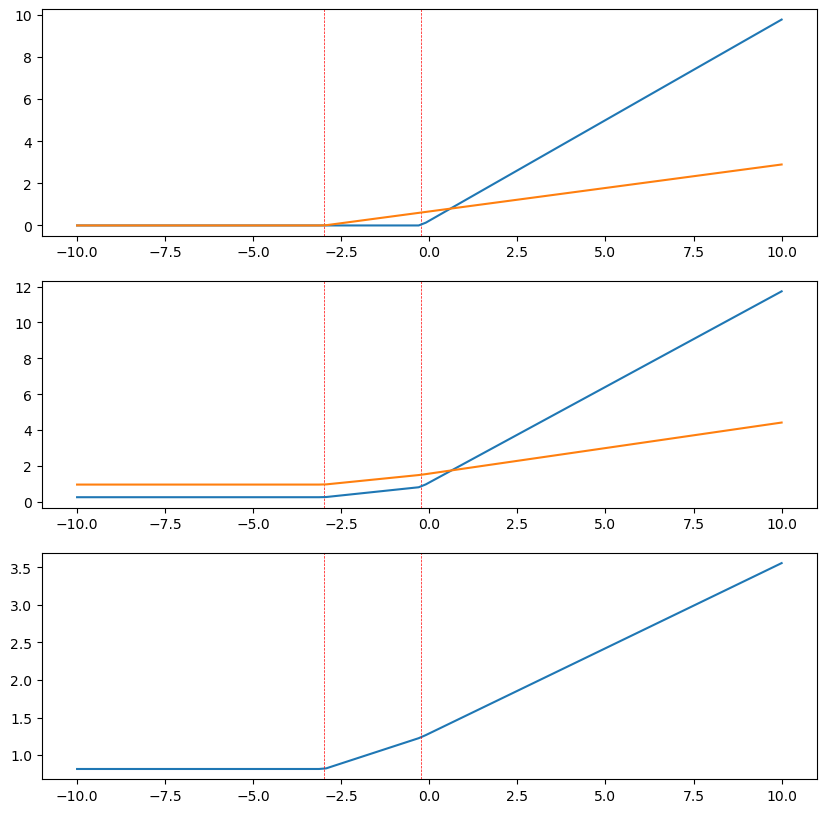

In [51]:
fig, axs = plt.subplots(3, 1, figsize=(10, 10))
x = np.linspace(-10, 10, 100)
x = torch.tensor(x).float().view(-1, 1)

# Plot the function defined by the model
with torch.no_grad():
    y = model(x)
axs[2].plot(x.numpy(), y.numpy(), label='Model output')

# Add vertical lines at the crossing points
for t in crossing_times:
    axs[0].axvline(t, color='r', linestyle='--', linewidth=0.5)
    axs[1].axvline(t, color='r', linestyle='--', linewidth=0.5)
    axs[2].axvline(t, color='r', linestyle='--', linewidth=0.5)

# Also plot the intermediate layer function on a separate plot
with torch.no_grad():
    y = torch.relu(model.fc1(x))
axs[0].plot(x.numpy(), y.numpy())

with torch.no_grad():
    y = torch.relu(model.fc2(y))
axs[1].plot(x.numpy(), y.numpy())

plt.show()

## Test general 2D input network

In [16]:
# TODO: Use gradient from torch
# TODO: Do you really want to use the last layer?

In [125]:
class FeedForwardNN(torch.nn.Module):
    def __init__(self):
        super(FeedForwardNN, self).__init__()
        self.fc1 = torch.nn.Linear(2, 2)
        self.fc2 = torch.nn.Linear(2, 1)
        self.init_weights_random()

    def init_weights(self):
        torch.nn.init.ones_(self.fc1.weight)
        torch.nn.init.ones_(self.fc2.weight)
        torch.nn.init.zeros_(self.fc1.bias)
        torch.nn.init.zeros_(self.fc2.bias)

    def init_weights_random(self):
        torch.nn.init.normal_(self.fc1.weight)
        torch.nn.init.normal_(self.fc2.weight)
        torch.nn.init.normal_(self.fc1.bias)
        torch.nn.init.normal_(self.fc2.bias)
    
    def forward(self, x):
        x = self.fc1(x)
        x = torch.relu(x)
        output = self.fc2(x)
        return output
    
model = FeedForwardNN()

In [141]:
def compute_crossing_times(model, t_values, direction):
    crossings = []
    x = direction * t_values.reshape((1, -1))
    x = torch.tensor(x).float()  # line 
    x = x.transpose(0, 1)
    tol = 1e-5

    for l,layer in enumerate(model.children()):      # iterate over layers
        with torch.no_grad():
            x = layer(x)
        activation = x>0
        for i in range(activation.shape[1]):    # iterate over neurons
            transition_indices = np.where(np.abs(np.diff(activation[:, i])) > tol)[0]
            for idx in transition_indices:
                crossings.append((l, i, t_values[idx]))
        x = torch.relu(x)
    crossing_times = [t for _,_,t in crossings]
    crossing_times = np.unique(crossing_times, axis=0)
    return crossing_times

def compute_gradients(model, crossing_times):
    dt = 1e-2
    grad = []

    t_min = crossing_times[0] - 2 * dt
    t_values = np.array([t_min, t_min + dt])
    x = direction * t_values.reshape((1, -1))
    x = torch.tensor(x).float().view(-1,2)
    with torch.no_grad():
        y = model(x)
    dy = np.diff(y.numpy().reshape(-1))
    grad.append(dy/dt)
    
    for t in crossing_times:
        t_values = np.array([t + dt, t + 2*dt])
        x = direction * t_values.reshape((1, -1))
        x = torch.tensor(x).float().view(-1,2)
        with torch.no_grad():
            y = model(x)
        dy = np.diff(y.numpy().reshape(-1))
        grad.append(dy/dt) 
    
    grad = np.array(grad)
    return grad

direction = np.array([1,-1]).reshape((2,1))
t_values = np.linspace(-20, 20, 1000)
crossing_times = compute_crossing_times(model, t_values, direction)
grad = compute_gradients(model, crossing_times)

for i in range(1, len(crossing_times)+1):
    if np.abs(grad[i-1] - grad[i]) < 1e-5:
        crossing_times = np.delete(crossing_times, i-1)

print(crossing_times)

[-0.54054054 -0.3003003   0.18018018]


In [142]:
# Plot the 3d function defined by the model

# pyton -m http.server 8000
# http://localhost:8000/interactive_plot.html

#direction = np.array([1,2]).reshape((2,1))
#t_values = np.linspace(-20, 20, 1000)

line = direction * t_values.reshape((1, -1))

x = np.linspace(-20, 20, 100)
y = np.linspace(-20, 20, 100)
x, y = np.meshgrid(x, y)
z = np.concatenate((x.reshape(-1, 1), y.reshape(-1, 1)), axis=1)
z = torch.tensor(z).float()
with torch.no_grad():
    z = model(z)
z = z.numpy().reshape(100, 100)
data = []
for t in crossing_times:
    data.append(go.Scatter3d(
        x=direction[0]*t,
        y=direction[1]*t,
        z=np.array(0),
        mode='markers',
        marker=dict(
            size=5,
            color='green',
        )
    ))
data.append(go.Surface(
        z=z,
        x=x,
        y=y,
        colorscale=[[0, 'black'], [1, 'black']],
        showscale=False,
        opacity=0.8,
        contours=dict(
            x=dict(show=False, color="white", width=2),  # Add meshlines along x
            y=dict(show=False, color="white", width=2),  # Add meshlines along y
            z=dict(show=True, color='White', width=2, size=0.5)  # Turn off z contours if not needed
        )
    )
)
data.append(
    go.Scatter3d(
        x=line[0,:],
        y=line[1,:],
        z=0.0*np.ones(1000),
        mode='markers',
        marker=dict(
            size=1,
            color='red',
        )
    )
)
fig = go.Figure(data=data)
        
fig.update_layout(title='Interactive 3D Plot')
fig.show()
fig.write_html("interactive_plot.html")

In [184]:
# Try counting the total number of regions in 2D
# Then : Plot the contour colored by the gradients (avoiding the crossing points)
# Then : Generalize this to 3D by intersecting with a plane

In [ ]:
# Other visualization:
# Partition this input space into regious where the output is linear
# Color each region with a different color

dx, dy = np.gradient(z, x, y)  # Numerical gradient
gradient_magnitude = np.sqrt(dx**2 + dy**2)

# TODO: Check what happens to the gradient when surface is not differentiable

data = [
    go.Contour(
        z=z,
        x=np.linspace(-20, 20, 100),
        y=np.linspace(-20, 20, 100),
        contours=dict(showlabels=False, start=0, end=np.max(gradient_magnitude), size=0.1, showlines=False),
        showscale=True
    )
]
data.append(
    go.Scatter(
        x=line[0,:],
        y=line[1,:],
        mode='markers',
        marker=dict(
            size=1,
            color='red',
        )
    )
)
fig = go.Figure(data=data)
fig.show()

[0.00000000e+00 1.77635684e-15 2.51214789e-15 5.63049205e-02
 6.22328408e-02 1.12700939e-01 1.31508380e-01 1.50314882e-01
 1.69121370e-01 1.87925056e-01 2.15070277e-01 2.20998198e-01
 3.42004061e-01 3.60810548e-01 3.79617035e-01 3.79763544e-01
 3.98423553e-01 4.17233795e-01 5.38527966e-01 5.44456840e-01
 5.90114594e-01 6.08922064e-01 6.27728522e-01 6.46535993e-01
 6.97293341e-01 7.03222215e-01 8.19417715e-01 8.38225126e-01
 8.56058657e-01 8.57030690e-01 8.61986578e-01 8.75838161e-01
 1.01482308e+00 1.02075195e+00 1.04872179e+00 1.06752825e+00
 1.08633006e+00 1.10514033e+00 1.17358851e+00 1.17951727e+00
 1.28298450e+00 1.30348134e+00 1.32419789e+00 1.33235288e+00
 1.33828270e+00 1.34511662e+00 1.40447628e+00 1.49111819e+00
 1.49704707e+00 1.54564047e+00 1.56820619e+00 1.59089649e+00
 1.61370611e+00 1.63662469e+00 1.64988363e+00 1.65581250e+00
 1.80864894e+00 1.81457686e+00 1.85196996e+00 1.87582910e+00
 1.89975536e+00 1.92375445e+00 1.96741331e+00 1.97334218e+00
 1.97716510e+00 2.126178

In [155]:
import numpy as np
import plotly.graph_objects as go

# Define the 2D function
def function(x, y):
    return np.where(x + y > 0, x+y, 0)

# Create a grid of x and y values
x = np.linspace(-2 * np.pi, 2 * np.pi, 100)
y = np.linspace(-2 * np.pi, 2 * np.pi, 100)
X, Y = np.meshgrid(x, y)

# Compute the function values
Z = function(X, Y)

# Calculate the gradient magnitude
dx, dy = np.gradient(Z, x, y)  # Numerical gradient
gradient_magnitude = np.sqrt(dx**2 + dy**2)
print(gradient_magnitude.shape)

# Create the contour plot
fig = go.Figure()

# Add the contour plot with gradient magnitude as colorscale
fig.add_trace(go.Contour(
    z=gradient_magnitude,
    x=x,  # x-axis values
    y=y,  # y-axis values
    colorscale="Viridis",
    contours=dict(showlabels=True, start=0, end=np.max(gradient_magnitude), size=0.1),
    showscale=True
))

# Update layout for better visuals
fig.update_layout(
    title="Contour Plot with Gradient-Based Colorscale",
    xaxis_title="X-axis",
    yaxis_title="Y-axis",
    coloraxis_colorbar=dict(title="Gradient Magnitude")
)

# Show the plot
fig.show()


(100, 100)
